In [1]:
import cv2
import os
from matplotlib import pyplot as plt
# all-in-one lib for various pre-trained NNs: https://gluon-cv.mxnet.io/index.html
from gluoncv import model_zoo, data, utils
import numpy as np
# for gpu usage to speed up compute
from mxnet import gpu # make sure correct mxnet version installed based on cuDNN driver

% matplotlib inline

In [2]:
root = './images/' # path to original uncropped images
save_filepath = './cropped/' # path to save cropped images
images = os.listdir(root)
image_filenames = [os.path.join(root, im) for im in images]

In [7]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True, ctx=gpu()) # for using gpu to speed it up

# Helper functions for auto-cropping batch of images

In [8]:
def detect_and_crop(images, save_path):
    # process and save each image individually to save memory
    for img in images:
        # Using yolov3 for segmentation
        x, orig_img = data.transforms.presets.yolo.load_test(img, short=416, max_size=1024)
        box_ids, scores, bboxes = net(x.as_in_context(gpu()))
        try:
            xmin, ymin, xmax, ymax = get_bounding_box_coords(bboxes[0], box_ids[0], scores[0])
            save_file = os.path.join(save_path, img.split('/')[-1])
            if xmax > xmin and ymax > ymin:
                cv2.imwrite(save_file,
                            cv2.cvtColor(orig_img[ymin:ymax, xmin:xmax],
                                         cv2.COLOR_BGR2RGB))
            else:
                print('ERROR:' + img)
        except:
            print('ERROR: ' + img)
    return True

def get_bounding_box_coords(bbox, box_id, score):
    """Returns left, bottom, right, top."""
    try:
        bbox = bbox.asnumpy()
        box_id = box_id.asnumpy()
        score = score.asnumpy()
        
        # sort by best person scores
        best_scores = np.argsort(score[box_id == 14])[::-1]
        for i in best_scores:
            best_box = bbox[np.where(box_id == 14)[0]][i]
            xmin, ymin, xmax, ymax = tuple(int(x) for x in best_box)
            if (xmax-xmin) * (ymax-ymin) >= 10000: # skip small persons
                return tuple(int(x) for x in best_box)
        raise ValueError('No Prediction.')
    except e:
        raise ValueError('No Prediction.')


In [9]:
detect_and_crop(image_filenames, save_filepath)

True

# Testing out & visualizing algorithms

* Faster R-CNN ResNet50 takes ~15-20s per image inference on CPU
* Yolo v3 MobileNet takes < 0.5s per image inference on CPU
* Yolo v3 Darknet takes ~2-4s per image inference on CPU
* Yolo v3 Darknet takes <0.5s per image inference on GPU crazy fast

## YOLOv3 - Darknet53 (main algorithm)

In [10]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)#, ctx=gpu())

In [11]:
imgname = '659584-Snakey-chartreuse-love-dress-black-zara-sandals.jpg'
x, orig_img = data.transforms.presets.yolo.load_test('./images/'+imgname,
                                                     short=416, max_size=1024)
box_ids, scores, bboxes = net(x)#.as_in_context(gpu()))

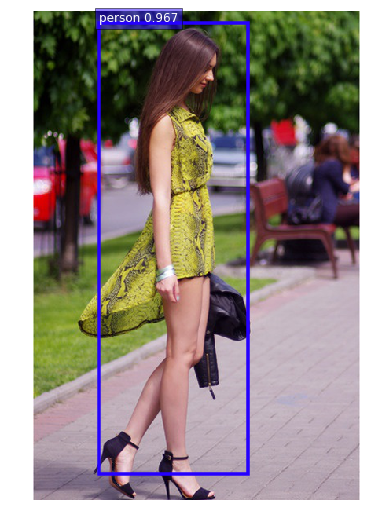

In [12]:
fig = plt.figure(figsize=(6,9))
a = plt.subplot(1,1,1)
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.5, ax=a)
plt.axis('off')
plt.show()

## Faster R-CNN - ResNet50

In [13]:
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)# cpu because gpu RAM too small

In [14]:
imgname = '659584-Snakey-chartreuse-love-dress-black-zara-sandals.jpg'
x, orig_img = data.transforms.presets.rcnn.load_test('./images/'+imgname,
                                                     short=416, max_size=1024)
box_ids, scores, bboxes = net(x)

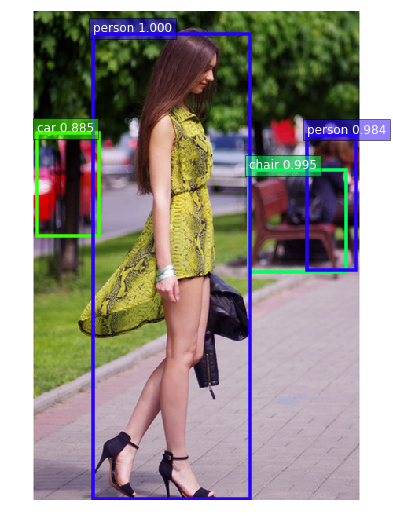

In [15]:
fig = plt.figure(figsize=(6,9))
a = plt.subplot(1,1,1)
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.5, ax=a)
plt.axis('off')
plt.show()

## YOLOv3 - MobileNet

In [16]:
net = model_zoo.get_model('yolo3_mobilenet1.0_voc', pretrained=True, ctx=gpu())

In [17]:
imgname = '659584-Snakey-chartreuse-love-dress-black-zara-sandals.jpg'
x, orig_img = data.transforms.presets.yolo.load_test('./images/'+imgname,
                                                     short=416, max_size=1024)
box_ids, scores, bboxes = net(x.as_in_context(gpu()))

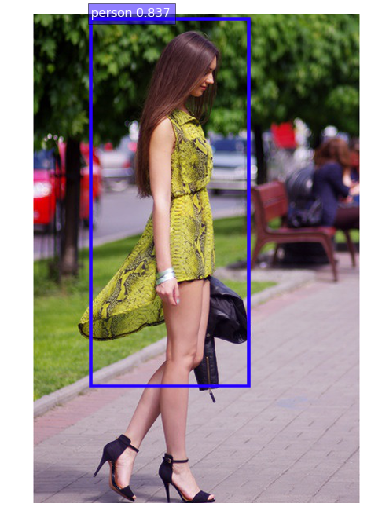

In [18]:
fig = plt.figure(figsize=(6,9))
a = plt.subplot(1,1,1)
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes, thresh=0.5, ax=a)
plt.axis('off')
plt.show()